In [1]:
import sys
sys.path.append("../..") 

In [2]:
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from src.data.data_loader import MIMIC3DataModule
from data.feature_sets import all_features,glycaemic_features

from src.models.base import BaseModel
from src.models.models import *

import matplotlib.pyplot as plt

In [3]:
# ARGS
N_EXAMPLE = 20
MAX_MEASURES = 10
CHK_PATH = "../../experiments/mimic3/sept28/version_2/checkpoints/epoch=29-step=2788.ckpt"
DATA_PATH = '../../data/analysis.csv'

In [4]:
# data
input_features = all_features()
mimic3 = MIMIC3DataModule(input_features,DATA_PATH)
mimic3.setup()
dl_test = mimic3.test_dataloader()

In [5]:
# model
checkpoint = torch.load(CHK_PATH)
hidden_dim = checkpoint["hyper_parameters"]['hidden_dim']
input_dim = checkpoint["hyper_parameters"]['input_dim']
NET = checkpoint["hyper_parameters"]['net']
model = locals()[NET](input_dim,hidden_dim)
model = model.load_from_checkpoint(checkpoint_path=CHK_PATH)

In [6]:
print(NET)
checkpoint["hyper_parameters"]

ctLSTMModel


{'RNN': ODELSTMCell(
   (ODENet): ODENetBase(
     (net): FF1(
       (net): Sequential(
         (0): Linear(in_features=12, out_features=24, bias=True)
         (1): Dropout(p=0.2, inplace=False)
         (2): Tanh()
         (3): Linear(in_features=24, out_features=12, bias=True)
       )
     )
   )
   (updateNN): UpdateNNBase(
     (net): LSTMCell(99, 12)
   )
 ),
 'OutputNN': GaussianOutputNN(
   (mu_net): Sequential(
     (0): Linear(in_features=12, out_features=6, bias=True)
     (1): Tanh()
     (2): Linear(in_features=6, out_features=1, bias=True)
   )
   (sigma_net): Sequential(
     (0): Linear(in_features=12, out_features=6, bias=True)
     (1): Tanh()
     (2): Linear(in_features=6, out_features=1, bias=True)
     (3): Softplus(beta=1, threshold=20)
   )
 ),
 'hidden_dim': 12,
 'input_dim': 99,
 'learning_rate': 0.01,
 'net': 'ctLSTMModel'}

In [7]:
x, y, msk, dt, _ = next(iter(dl_test))

In [8]:
def ginv(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

In [9]:
def join_trajectories(preds_j):
    """
    One person preds
    """
    mu = []
    sigma = []
    for t in range(len(preds_j)):
        mu.append(np.array([p[0].item() for p in preds_j[t]]))
        sigma.append(np.array([p[1].item() for p in preds_j[t]]))
    return np.concatenate(mu),np.concatenate(sigma)

In [10]:
def time_trajectories(dt_j,nsteps):
    ts = []
    for t in range(dt_j.size(0)):
        ts.append(np.linspace(dt_j[t][0],dt_j[t][1],nsteps))
    return np.concatenate(ts)

In [11]:
def obs_data(x_j,y_j,dt_J):
    ys = torch.cat((x_j[:,0][0].unsqueeze(0),y_j))
    ts = torch.cat((dt_j.squeeze(0)[0],dt_j.squeeze(0)[1:,1]))
    return ys.numpy(),ts.numpy()

In [12]:
def plot_trajectory(t_j,ys_j,ts_j,mu_tj,sigma_tj):
    levels = np.linspace(0.1, 1.0, 5)
    fig, ax = plt.subplots()
    ax.scatter(t_j,ginv(ys_j),color='r')
    for level in levels:
        ax.fill_between(ts_j, ginv(mu_tj - level*sigma_tj), 
                        ginv(mu_tj + level*sigma_tj), color='b', alpha=.1, edgecolor='w')
    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Blood glucose (mg/dL)")

In [13]:
def predict_and_plot_trajectory(dt_j,x_j,y_j,nsteps=6):
    preds = model.forward_trajectory(dt_j,x_j,nsteps=nsteps)
    ts_j = time_trajectories(dt_j.squeeze(0),nsteps+1)
    mu_tj,sigma_tj = join_trajectories(preds)
    ys_j,t_j = obs_data(x_j.squeeze(0),y_j,dt_j.squeeze(0))
    plot_trajectory(t_j,ys_j,ts_j,mu_tj,sigma_tj)

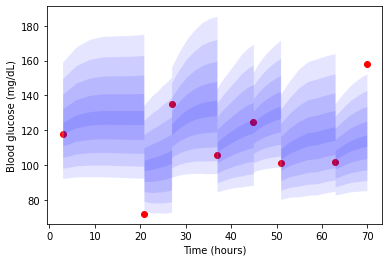

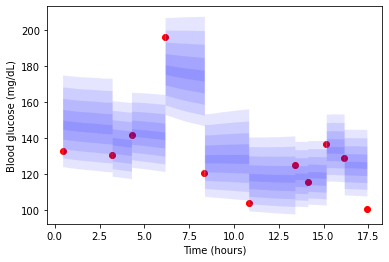

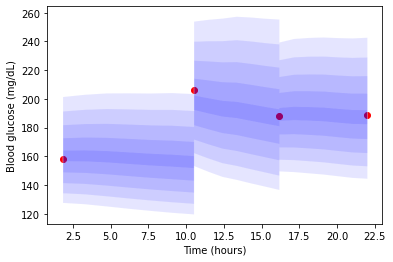

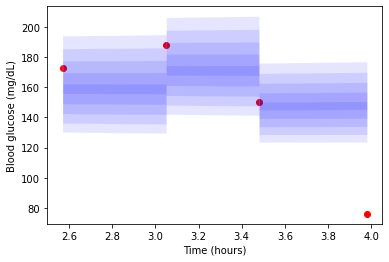

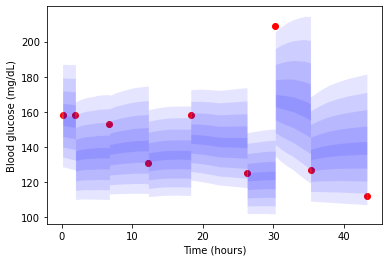

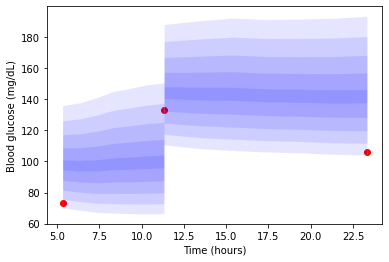

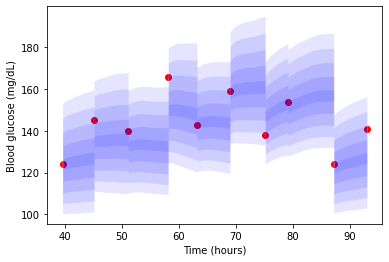

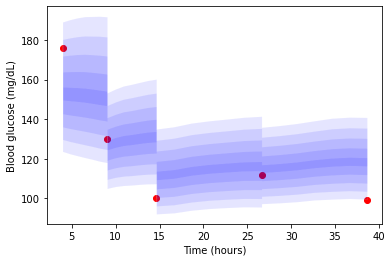

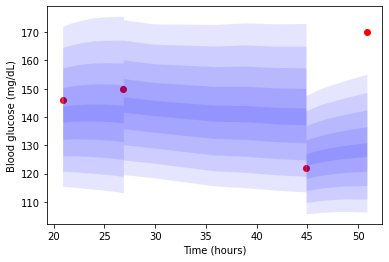

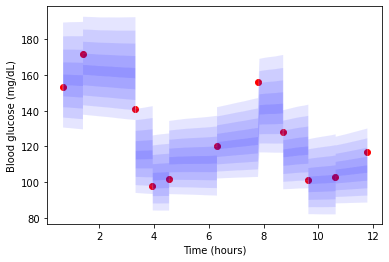

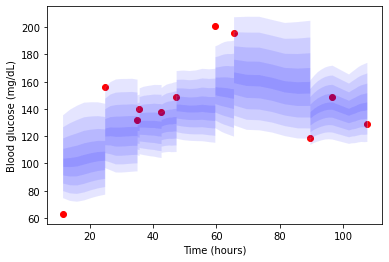

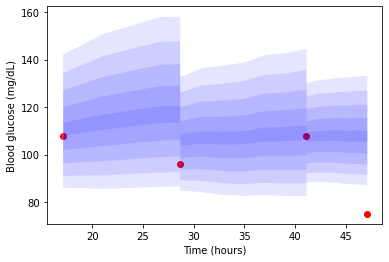

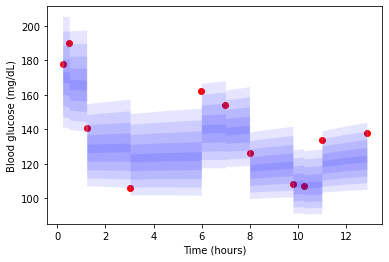

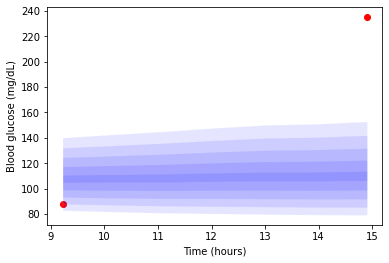

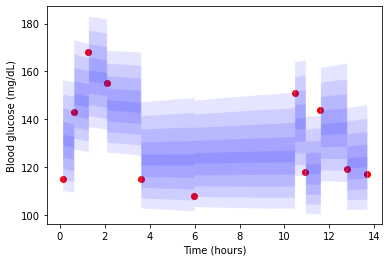

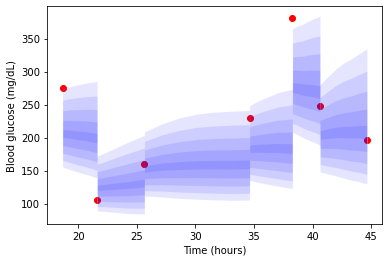

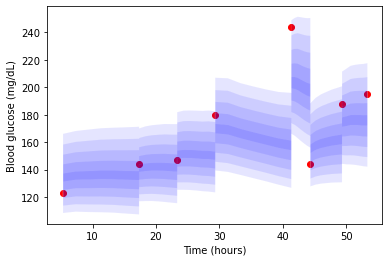

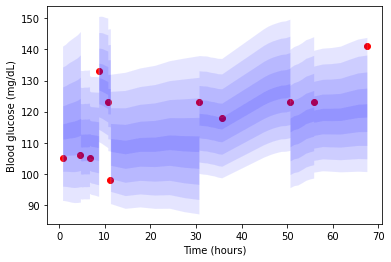

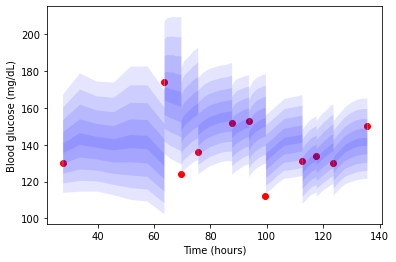

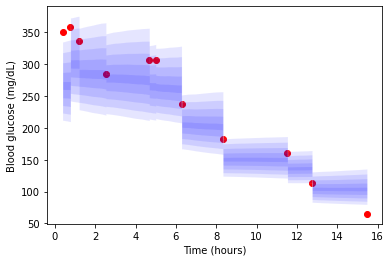

In [14]:
for i in range(N_EXAMPLE):
    dt_j = dt[i][~msk[i].bool()].unsqueeze(0)[:,0:MAX_MEASURES,:]
    x_j = x[i][~msk[i].bool()].unsqueeze(0)[:,0:MAX_MEASURES,:]
    y_j = y[i][~msk[i].bool()][0:MAX_MEASURES]
    predict_and_plot_trajectory(dt_j,x_j,y_j)